# <CENTER> **PROJECT: Semantic text search**

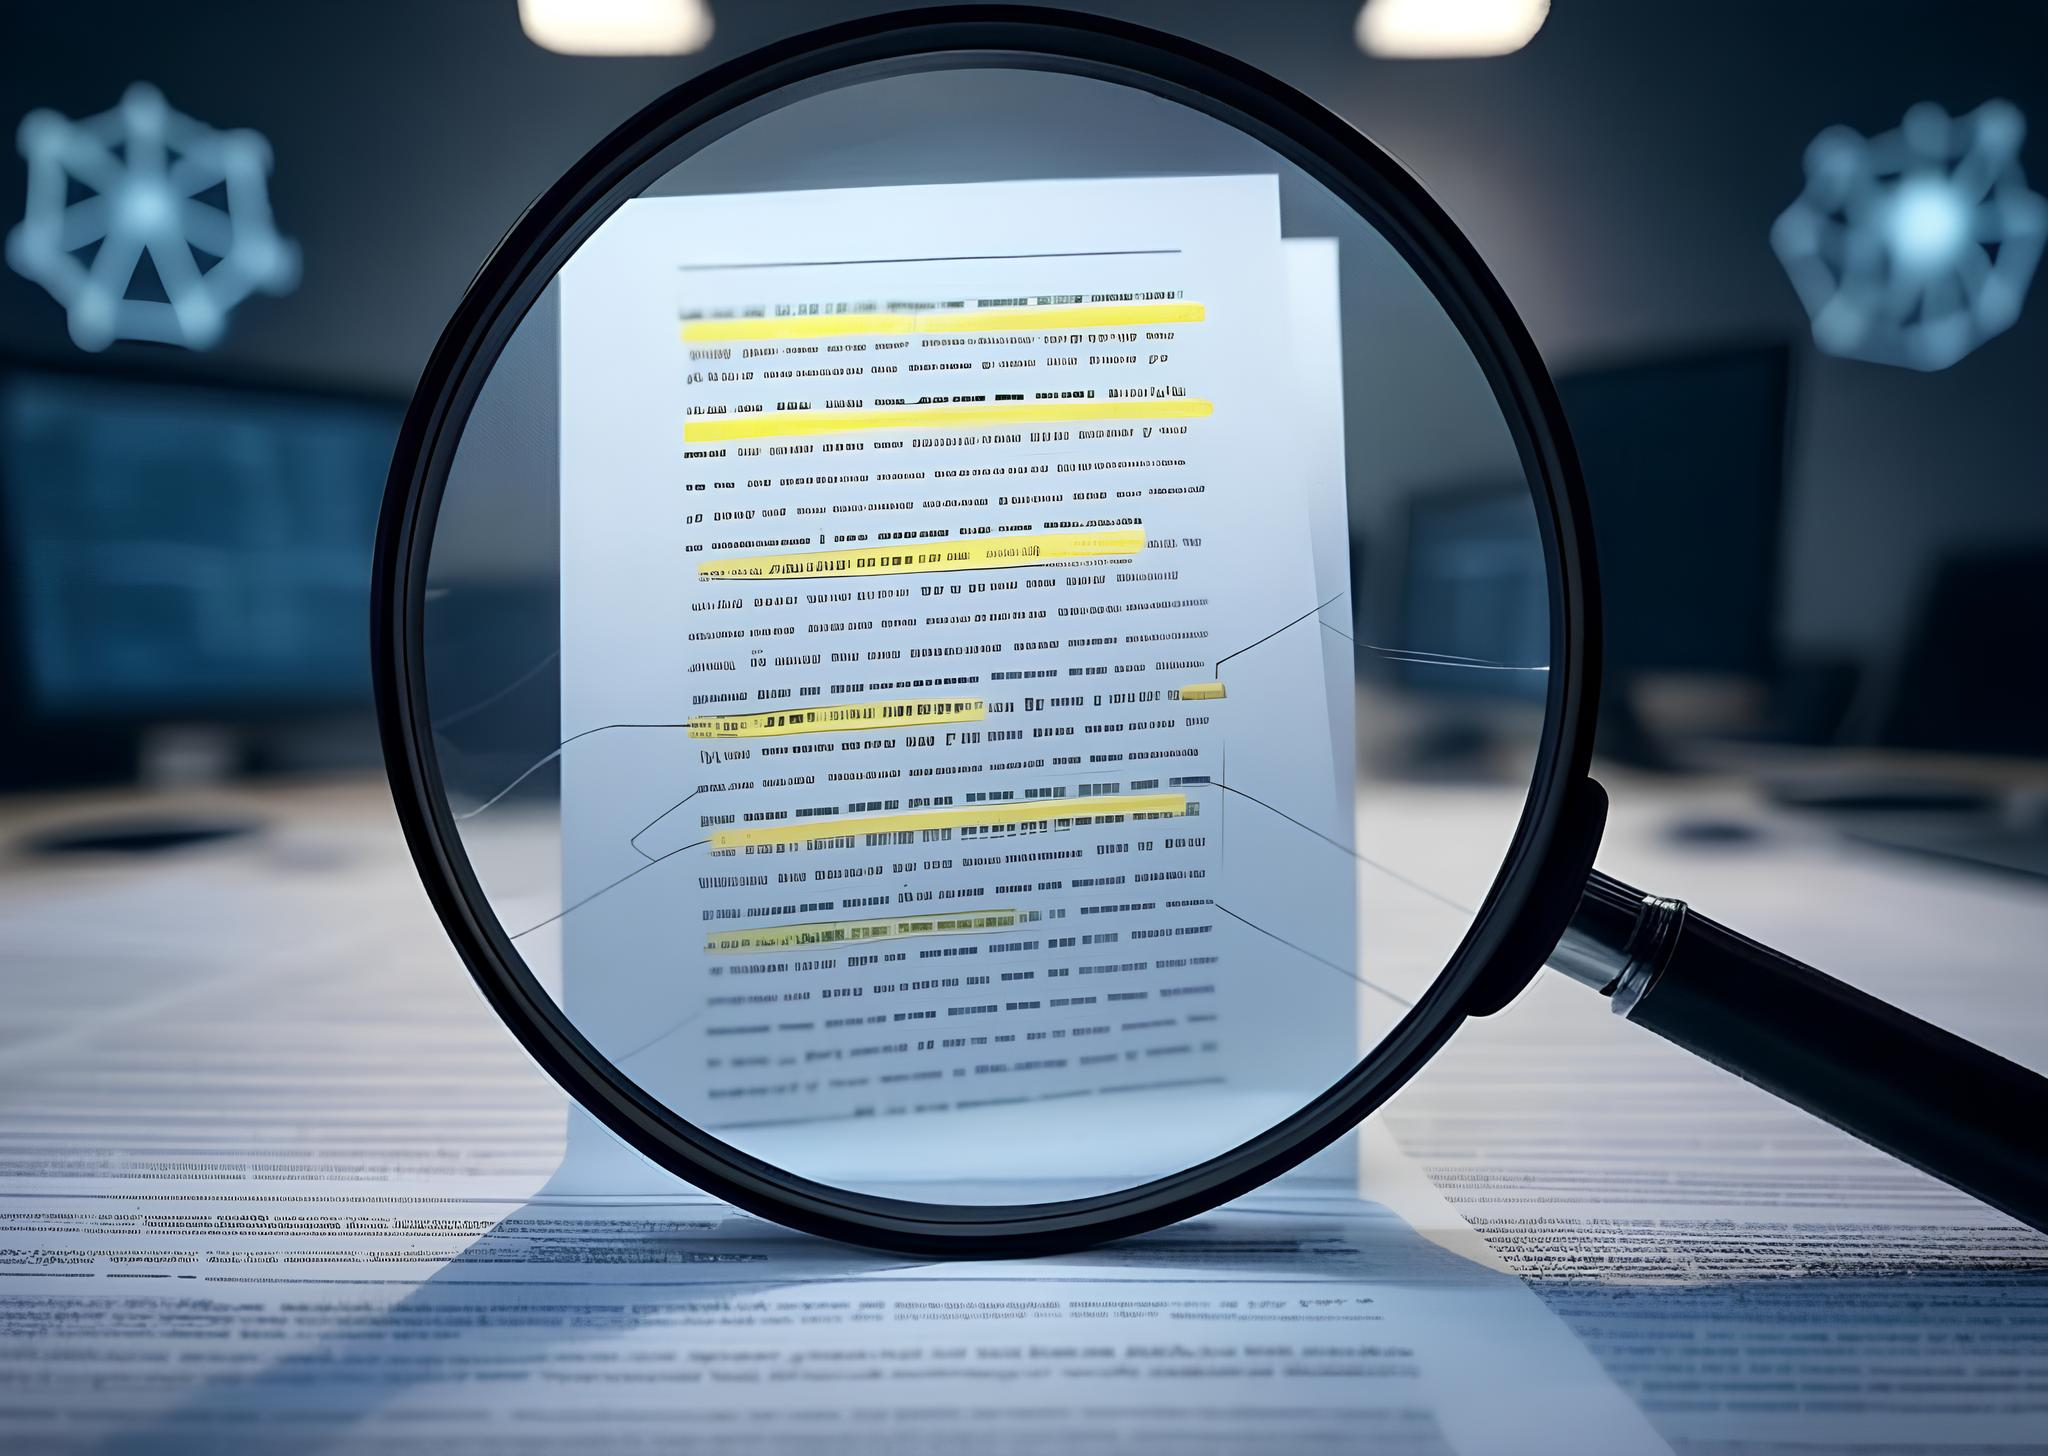

---

#### **Цель и ожидаемый результат:**

Создать систему семантического текстового поиска слов (словосочетаний) в документах, учитывающую не только точное написание, но и смысловое значение.
Результатом должно быть определение позиции найденного слова/словосочетания в тексте и оценка вероятности совпадения.

Желательно реализовать примитивный веб-интерфейс (UI) для ручного тестирования.

---

#### **Технические требования:**

* Язык разработки — Python;

* Все тексты — на русском языке, приведены к нижнему регистру, без пунктуации;

* Максимальная длина документа — 30 слов;

* Словосочетания — не более 2 слов в базовой форме.

---

#### **Этапы работы над проектом:**

Проект будет состоять из трёх частей:

`1.` *Базовый анализ и знакомство с данными*;

`2.` *Очистка данных*;

`3.` *Разведывательный анализ данных (EDA)*;

`4.` *Machine Learning*.

---

**Импортируем необходимые библиотеки:**

In [41]:
# Для работы с данными
import pandas as pd
import numpy as np
import pymorphy3
import re
import joblib
import os
os.environ["USE_TF"] = "0"


# Для построения графиков
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk import ngrams
nltk.download('punkt')
nltk.download('stopwords')


# Для построения модели
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from keybert import KeyBERT

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Загрузка данных:**

In [3]:
# Ссылка на raw-версию CSV
url = 'https://raw.githubusercontent.com/JarikDev/code_n_conquer/master/src/ml/data/1.csv'

# Загружаем данные
text_data = pd.read_csv(url)

# Копия датасета
text_df = text_data.copy()

## <CENTER> **`1.` Базовый анализ и знакомство с данными**

На данном этапе изучим информацию предоставленных данных.

#### $1.1$

Выведем информацию по таблице:

In [4]:
# Выводим размеры таблицы
print('Данные имеют следующую размерность:\n')
print('Количество строк: {};\nКоличество признаков (столбцов): {}.'.format(text_df.shape[0], text_df.shape[1]))
print('-' * 40)


# Выведем первые пять строк 
display(text_df.head())
print('-' * 110)

Данные имеют следующую размерность:

Количество строк: 1000;
Количество признаков (столбцов): 3.
----------------------------------------


doc_text  \
0  Твой лучший секс спрятан здесь 🔞  Делюсь канал...   
1  ⭐️  Кнопка: ⭐️START⭐️(https://t.me/major/start...   
2  А продолжение где? Правильно. В моем сообществ...   
3  Тем временем моя авторская телега уверенно в т...   
4  У меня есть двоюродная сестра, у нее есть сын ...   

                                          image2text speech2text  
0                                                NaN         NaN  
1                                                NaN         NaN  
2  девчонки не умеют переписываться sanille они э...         NaN  
3  10:42 nuil пул telegram ^ 51 142 подписчика 12...         NaN  
4  т с не ^ е z 8 * \"8 ничего не знала о стендап...         NaN

--------------------------------------------------------------------------------------------------------------


#### $1.2$

Выведем информацию по признакам:

In [5]:
# Вывод таблицы
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     1000 non-null   object
 1   image2text   568 non-null    object
 2   speech2text  338 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB


Подсчитаем количество по типам признаков:

In [11]:
# Подсчет количества признаков типа 'object', 'int64' и 'float64'      
object_columns_count = text_df.select_dtypes(include = ['object']).shape[1]
int64_columns_count = text_df.select_dtypes(include = ['int64']).shape[1]
float64_columns_count = text_df.select_dtypes(include = ['float64']).shape[1]


# Вывод результата
print('В данных представлены признаки следующих типов:\n')
print(f"Количество признаков типа 'object': {object_columns_count}")
print(f"Количество признаков типа 'int64': {int64_columns_count}")
print(f"Количество признаков типа 'float64': {float64_columns_count}")

В данных представлены признаки следующих типов:

Количество признаков типа 'object': 3
Количество признаков типа 'int64': 0
Количество признаков типа 'float64': 0


#### $1.3$

Выведем описательные характеристики по признакам:

In [6]:
# Вывод таблицы
text_df.describe()

doc_text image2text  \
count                                                1000        568   
unique                                                956        520   
top     Больше меня тут:  ТГ:  https://t.me/sobolevtel...  карта дня   
freq                                                   12          7   

                                              speech2text  
count                                                 338  
unique                                                331  
top     Вот и настал долгожданный день. Сегодня с 19.0...  
freq                                                    2

#### $1.4$

Проверим данные на наличие пропусков:

Суммарное количество пропусков в данных: 1094 

--------------------------------------------------
Информация по количествам пропусков: 

doc_text         0
image2text     432
speech2text    662
dtype: int64 

--------------------------------------------------
Информация по количествам пропусков в процентах:

speech2text    66.2
image2text     43.2
dtype: float64
--------------------------------------------------


<Axes: title={'center': 'Тепловая карта пропущенных значений'}>

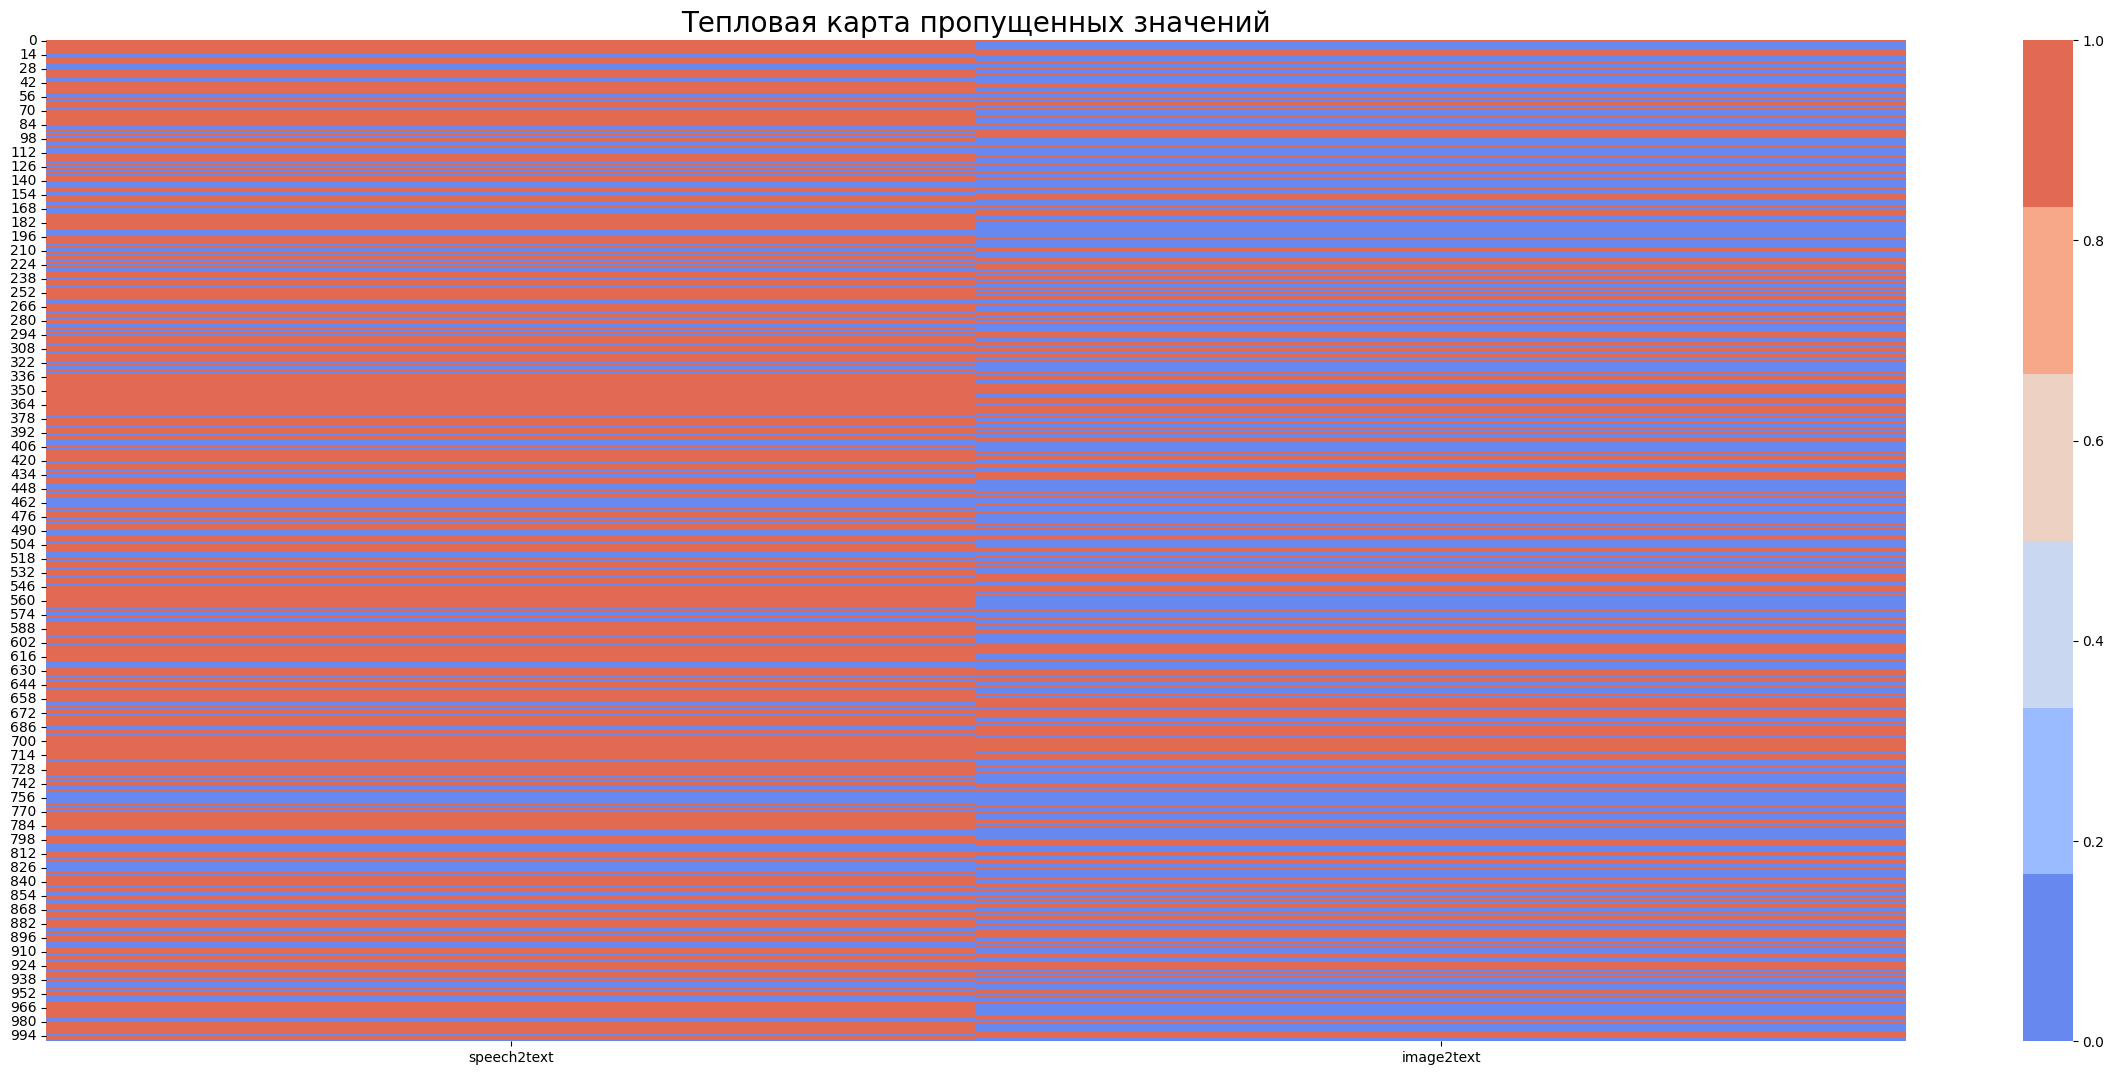

In [12]:
# Выводим суммарное количество пропусков
print('Суммарное количество пропусков в данных: {} \n'.format(text_df.isnull().sum().sum()))
print('-' * 50)

# Выводим признаки с сумрным количеством пропусков
print('Информация по количествам пропусков: \n\n{} \n'.format(text_df.isnull().sum()))
print('-' * 50)



# Построим тепловую карту пропусков
# Создаём функцию отображения пропущенных значений на тепловой карте
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(f'Информация по количествам пропусков в процентах:\n\n{cols_with_null}')
    print('-' * 50)
    
    # Задаём параметры графика
    colors = sns.color_palette('coolwarm')
    fig = plt.figure(figsize = (30, 13))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    # Задаём название графика
    plt.title('Тепловая карта пропущенных значений', fontsize = 20)
    
    return ax



# Применяем полученную функцию к нашему датасету
missing_values_heatmap(text_df)

**Вывод:**

Как видно из полученного графика, количество пропусков в данных составляет от $43$% до $66$%.

Необходима предобработка данных.

#### $1.5$

Проверяем данные на наличие дубликатов:

In [13]:
# Создаём список признаков
dupl_columns = list(text_df.columns)


# Создаём маску дубликатов с помощью метода duplicated() и произведём фильтрацию
mask = text_df.duplicated(subset = dupl_columns)
train_duplicates = text_df[mask]
print(f'Число найденных дубликатов: {train_duplicates.shape[0]}')

Число найденных дубликатов: 8


#### $1.6$

Данные содержат колонку `doc_text` с текстами документов. Мы будем использовать эту колонку для поиска:

In [7]:
# Выделяем признак 'doc_text' и превращаем его в список
documents = text_df['doc_text'].tolist()



# Выводим результат
print('Данные содержат тексты документов следующего содержания:')
print('-' * 60)
print()

display(documents)

Данные содержат тексты документов следующего содержания:
------------------------------------------------------------



['Твой лучший секс спрятан здесь 🔞  Делюсь каналом дипломированного сексолога. Крис взломала код классного секса, мастерски раскрепощает, знает миллион горячих техник и лучшие девайсы для взрослых 😻  Самые полезные посты здесь:   Отрезвляющий пост «Я все сама!»   Прокачай наездницу  Ролевая игра «VIP кинотеатр»   Техника оральных ласк 💣   Как занимается сeксом неудобная женщина   Кстати, Крис провела трехдневный безоплатный онлайн интенсив-«От бревна до Богини». Совместно с врачом и владельцем секс-шопа.   Скорее смотри записи, пока не удалила 🔞  https://t.me/sekretskris/1048   Здесь жарче, чем в аду 😈',
 '⭐️  Кнопка: ⭐️START⭐️(https://t.me/major/start?startapp=1972869792)',
 'А продолжение где? Правильно. В моем сообществе в ВК. Ссылка в шапке профиля.',
 'Тем временем моя авторская телега уверенно в тройке сильнейших!!! Компания мощная!!! Ухххх!!! 💪',
 'У меня есть двоюродная сестра, у нее есть сын Антон, мой двоюродный племянник получается) Он снимает свой подкаст, конечно я пришла 

## <CENTER> **`2.` Очистка данных**

На данном этапе проведём следующую предобработку:

* Приведём данные к нижнему регистру;

* Удалим пунктуацию, эмодзи и специальные символы;

* Удалим лишние пробелы;

* Удалим дубликаты.

#### $2.1$

Создадим функцию для предобработки:

In [8]:
# Функция для очистки текста
def clean_text(text):
    
    """
    Очищает текст, приводя его к нижнему регистру и удаляя пунктуацию.

    Args:
        text (str): Входной текст для очистки.

    Returns:
        str: Очищенный текст в нижнем регистре, без пунктуации и лишних пробелов.
    """
    
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Удаляем пунктуацию, эмодзи и специальные символы (оставляем буквы, цифры, пробелы)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Применяем полученную функцию к данным:

In [9]:
# Очищаем документы
cleaned_documents = [clean_text(doc) for doc in documents]



# Выводим результат
print('Результат после очистки данных:')
print('-' * 35)
print()

display(cleaned_documents)

Результат после очистки данных:
-----------------------------------



['твой лучший секс спрятан здесь делюсь каналом дипломированного сексолога крис взломала код классного секса мастерски раскрепощает знает миллион горячих техник и лучшие девайсы для взрослых самые полезные посты здесь отрезвляющий пост я все сама прокачай наездницу ролевая игра vip кинотеатр техника оральных ласк как занимается сeксом неудобная женщина кстати крис провела трехдневный безоплатный онлайн интенсивот бревна до богини совместно с врачом и владельцем сексшопа скорее смотри записи пока не удалила httpstmesekretskris1048 здесь жарче чем в аду',
 'кнопка starthttpstmemajorstartstartapp1972869792',
 'а продолжение где правильно в моем сообществе в вк ссылка в шапке профиля',
 'тем временем моя авторская телега уверенно в тройке сильнейших компания мощная ухххх',
 'у меня есть двоюродная сестра у нее есть сын антон мой двоюродный племянник получается он снимает свой подкаст конечно я пришла его поддержать получилось честное и откровенное интервью смотрите httpsyoutubeaifyxpjaa1qs

#### $2.2$

**Удаление дубликатов.**

Также ранее было обнаружено $6$ дубликатов, удалим их:

In [63]:
# Удаляем найденные дубликаты
text_df = text_df.drop_duplicates(subset = dupl_columns)


# Заново создаём маску дубликатов с помощью метода duplicated() и выводим количество оставшихся дубликатов
mask = text_df.duplicated(subset = dupl_columns)
train_duplicates = text_df[mask]
print(f'Число найденных дубликатов: {train_duplicates.shape[0]}')

Число найденных дубликатов: 0


## <CENTER> **`3.` Разведывательный анализ данных (EDA)**

В данной части проекта мы:

* изучаем сгенерированный набор данных;

* дополним наш анализ визуализациями, иллюстрирующими исследование.

#### $3.1$

**Анализ длины текстов.**

Создадим новые колонки для длины текстов в символах и словах. Подсчитаем основные статистики: среднюю длину, медиану, минимальную и максимальную длину:

In [19]:
# Подсчет длины текстов
text_df['text_length_chars'] = text_df['doc_text'].apply(len)
text_df['text_length_words'] = text_df['doc_text'].apply(lambda x: len(x.split()))



# Основные статистики
print('Статистики длины текстов:')
print('-' * 25)
print()

print(text_df[['text_length_chars', 'text_length_words']].describe())
print('-' * 50)

Статистики длины текстов:
-------------------------

       text_length_chars  text_length_words
count        1000.000000        1000.000000
mean          483.030000          63.351000
std           698.470161          97.465827
min             8.000000           1.000000
25%           116.750000          14.000000
50%           219.000000          26.000000
75%           546.250000          69.000000
max          8146.000000        1092.000000
--------------------------------------------------


Так же вычислим тексты, которые слишком короткие (например, < $5$ символов) или слишком длинные (например, > $1000$ слов). Проверим, являются ли короткие тексты пропусками или неинформативными (например, `"нет"`, `"ок"`):

In [21]:
# Проверка аномалий
short_texts = text_df[text_df['text_length_chars'] < 5]
long_texts = text_df[text_df['text_length_words'] > 1000]

# Выводим результат
print(f'Короткие тексты ( < 5 символов): {len(short_texts)}')
print(f'Длинные тексты ( > 1000 слов): {len(long_texts)}')

Короткие тексты ( < 5 символов): 0
Длинные тексты ( > 1000 слов): 1


Построим гистограмму длины текстов в словах и символах. Так же создадим коробчатую диаграмму (boxplot) для выявления выбросов:

------------------------------------------------------------------------------------------------------------------------------------------------------
Гистограмма длины текстов в словах и символах:


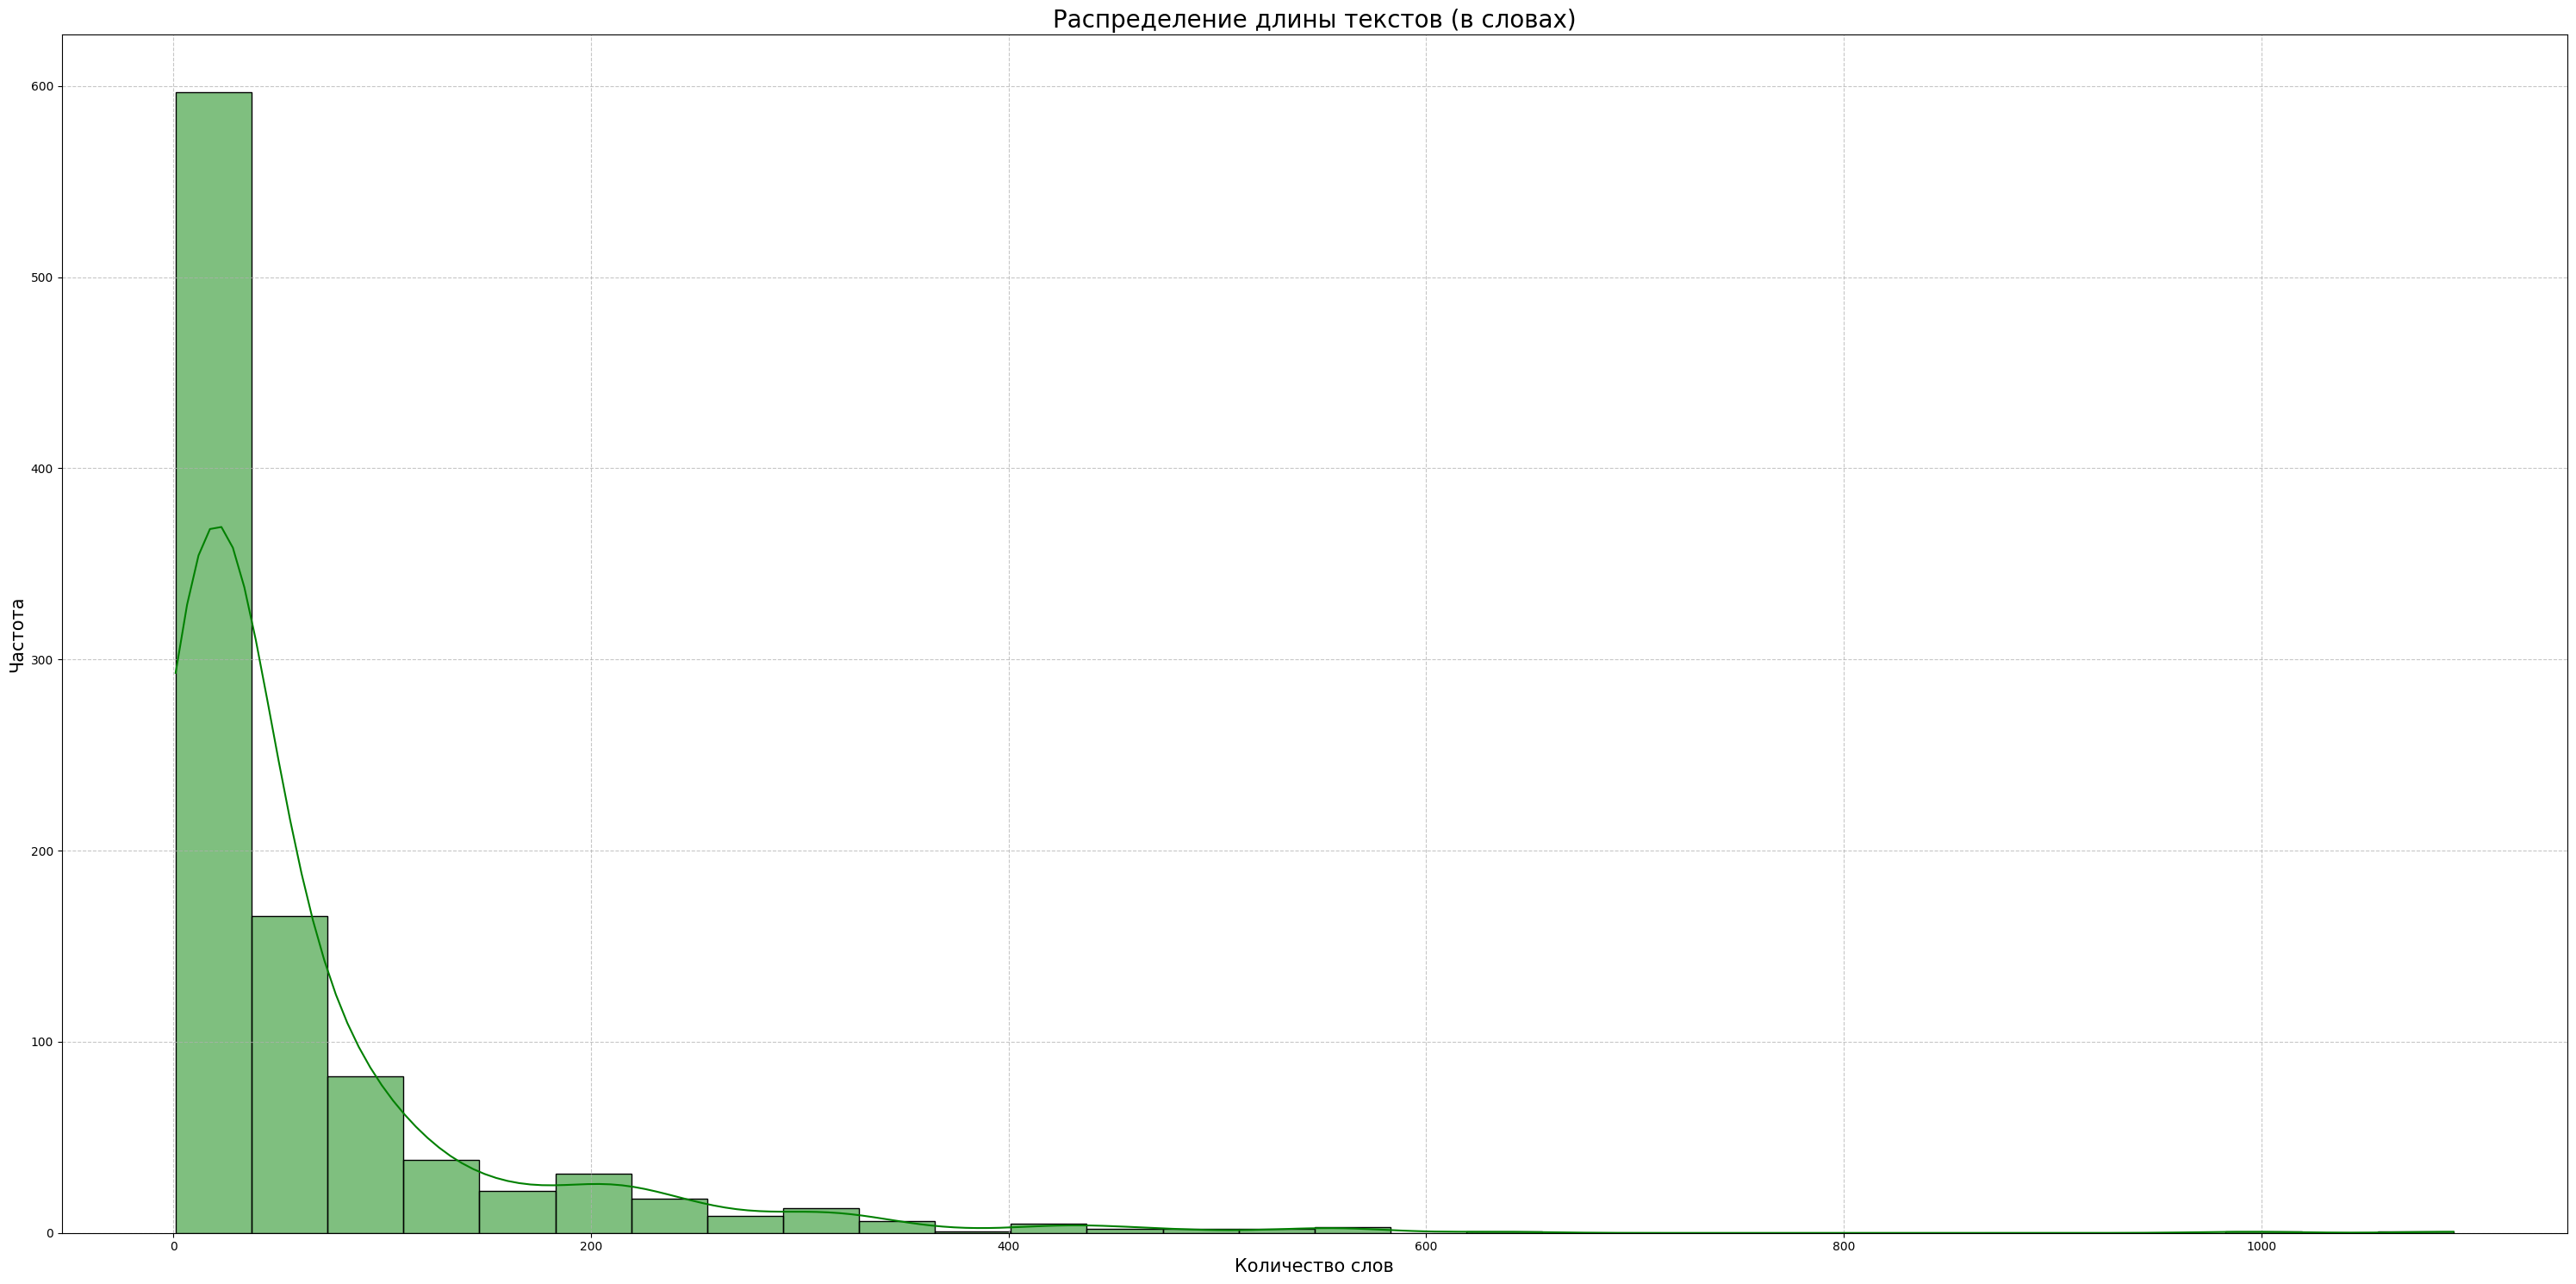

------------------------------------------------------------------------------------------------------------------------------------------------------
Коробчатая диаграмма выбросов


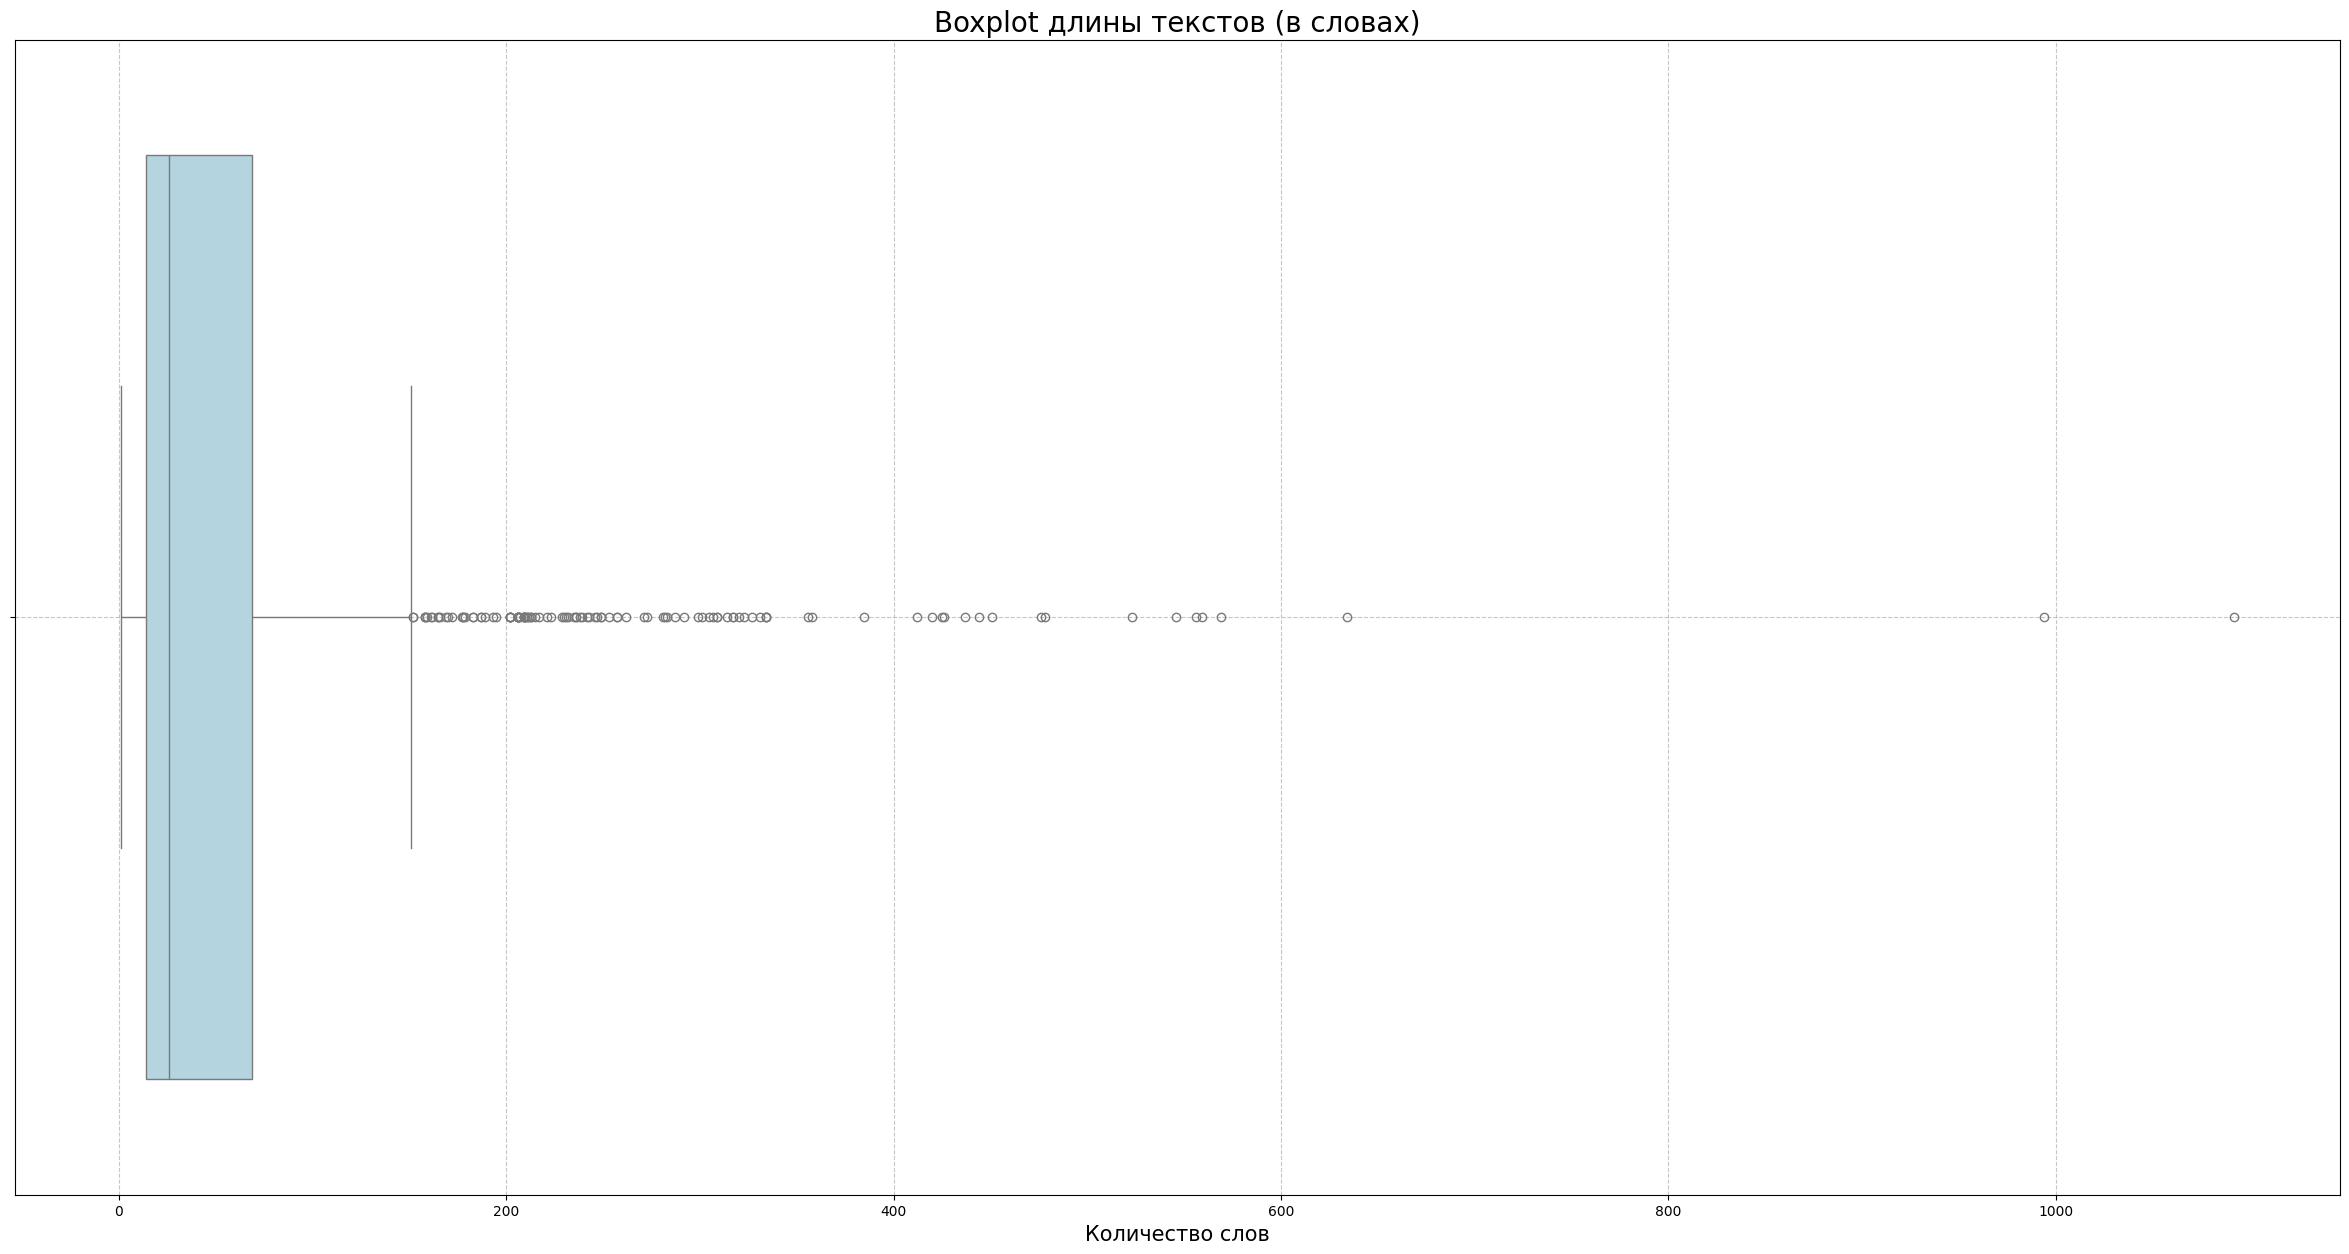

------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Задаём заглавие для гистограммы
print('-' * 150)
print('Гистограмма длины текстов в словах и символах:')

# Визуализация длины текстов
plt.figure(figsize = (30, 15))
sns.histplot(text_df['text_length_words'], bins=30, kde=True, color='green')
plt.title('Распределение длины текстов (в словах)', fontsize = 20)
plt.xlabel('Количество слов', fontsize = 15)
plt.ylabel('Частота', fontsize = 15)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()
print('-' * 150)




# Boxplot для выбросов
print('Коробчатая диаграмма выбросов:')

plt.figure(figsize = (30, 15))
sns.boxplot(x=text_df['text_length_words'], color='lightblue')
plt.title('Boxplot длины текстов (в словах)', fontsize = 20)
plt.xlabel('Количество слов', fontsize = 15)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.show()
print('-' * 150)

#### $3.2$

**Анализ текстового содержимого.**

Разбобъём тексты на слова, затем удалим стоп-слова и знаки препинания. После чего подсчитаем общее количество слов и уникальных слов (словарный запас):

In [30]:
# Токенизация и очистка
stop_words = set(stopwords.words('russian'))
all_words = []

for text in text_df['doc_text']:
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    all_words.extend(tokens)



# Подсчет частоты слов
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)



# Выводим результат
print(f'Топ-10 слов: {common_words}')

Топ-10 слов: [('https', 1807), ('это', 329), ('п', 246), ('выпуск', 152), ('видео', 134), ('канал', 118), ('новый', 112), ('шоу', 105), ('очень', 101), ('моем', 93)]


Выведем 'Топ-10' биграмм:

In [32]:
# Биграммы
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(10)


# Выводим результат
print(f'Топ-10 биграмм: {bigram_freq}')

Топ-10 биграмм: [(('https', 'п'), 190), (('https', 'https'), 182), (('grishin', 'club'), 79), (('прикреплённые', 'ссылки'), 56), (('ссылки', 'https'), 52), (('ссылке', 'https'), 51), (('сольный', 'концерт'), 46), (('новый', 'выпуск'), 41), (('https', 'прикреплённые'), 36), (('telegram', 'https'), 34)]


Строим таблицу биграмм:

In [48]:
# Токенизация и очистка текстов
stop_words = set(stopwords.words('russian'))
all_words = []

for text in documents:
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    all_words.extend(tokens)



# Формирование биграмм
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(10)

# Подготовка данных для таблицы
bigram_list = [(f"{bigram[0]} {bigram[1]}", count) for bigram, count in bigram_freq]
bigram_df = pd.DataFrame(bigram_list, columns=['Биграмма', 'Частота'])

# Вывод таблицы
print('Таблица топ-10 биграмм:')
print('-' * 20)
print()

print(bigram_df)

Таблица топ-10 биграмм:
--------------------

               Биграмма  Частота
0               https п      190
1           https https      182
2          grishin club       79
3  прикреплённые ссылки       56
4          ссылки https       52
5          ссылке https       51
6       сольный концерт       46
7          новый выпуск       41
8   https прикреплённые       36
9        telegram https       34


Строим график:

------------------------------------------------------------------------------------------------------------------------------------------------------
Гирафик наиболее частых биграмм:


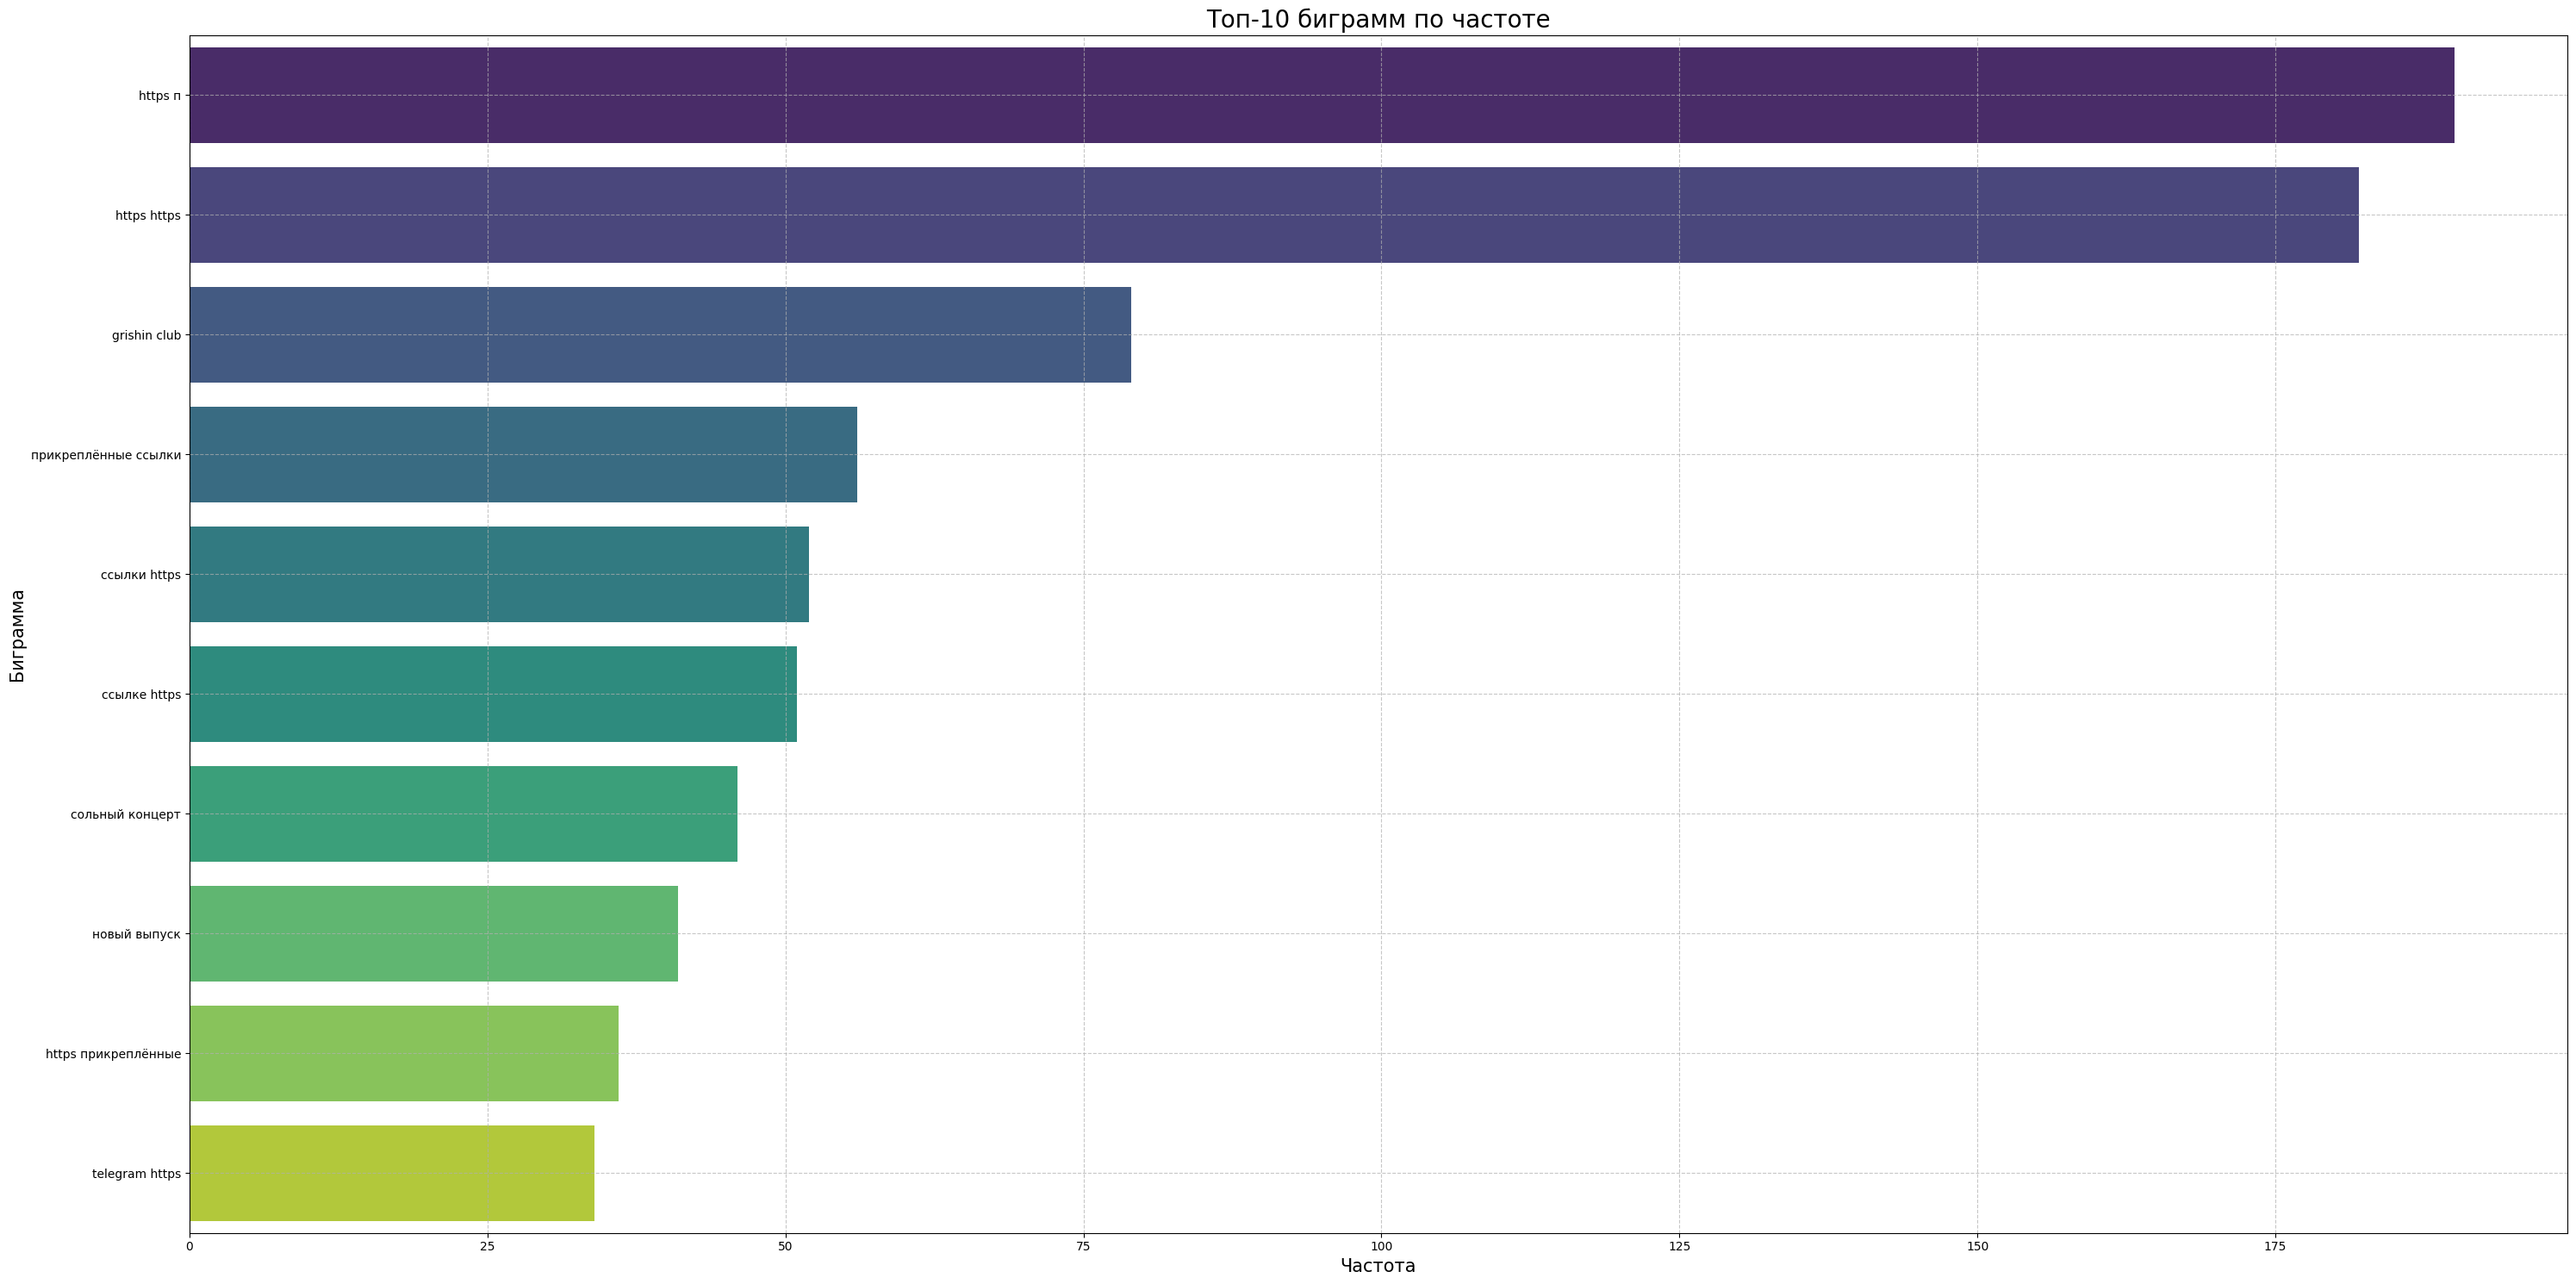

In [50]:
# Задаём заглавие для гистограммы
print('-' * 150)
print('Гирафик наиболее частых биграмм:')


# Задаём размер графика
plt.figure(figsize = (30, 15))

# Строим график
sns.barplot(
    data = bigram_df,
    x = 'Частота', 
    y = 'Биграмма', 
    palette = 'viridis'
)

# Настраиваем оформление
plt.title('Топ-10 биграмм по частоте', fontsize = 20)
plt.xlabel('Частота', fontsize = 15)
plt.ylabel('Биграмма', fontsize = 15)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.tight_layout()

# Отображаем график
plt.show()

Теперь Построим облако слов (`wordcloud`) для всех текстов. Так же создадим график топ-10 самых частых слов:

------------------------------------------------------------------------------------------------------------------------------------------------------
Облако (wordcloud) слов:


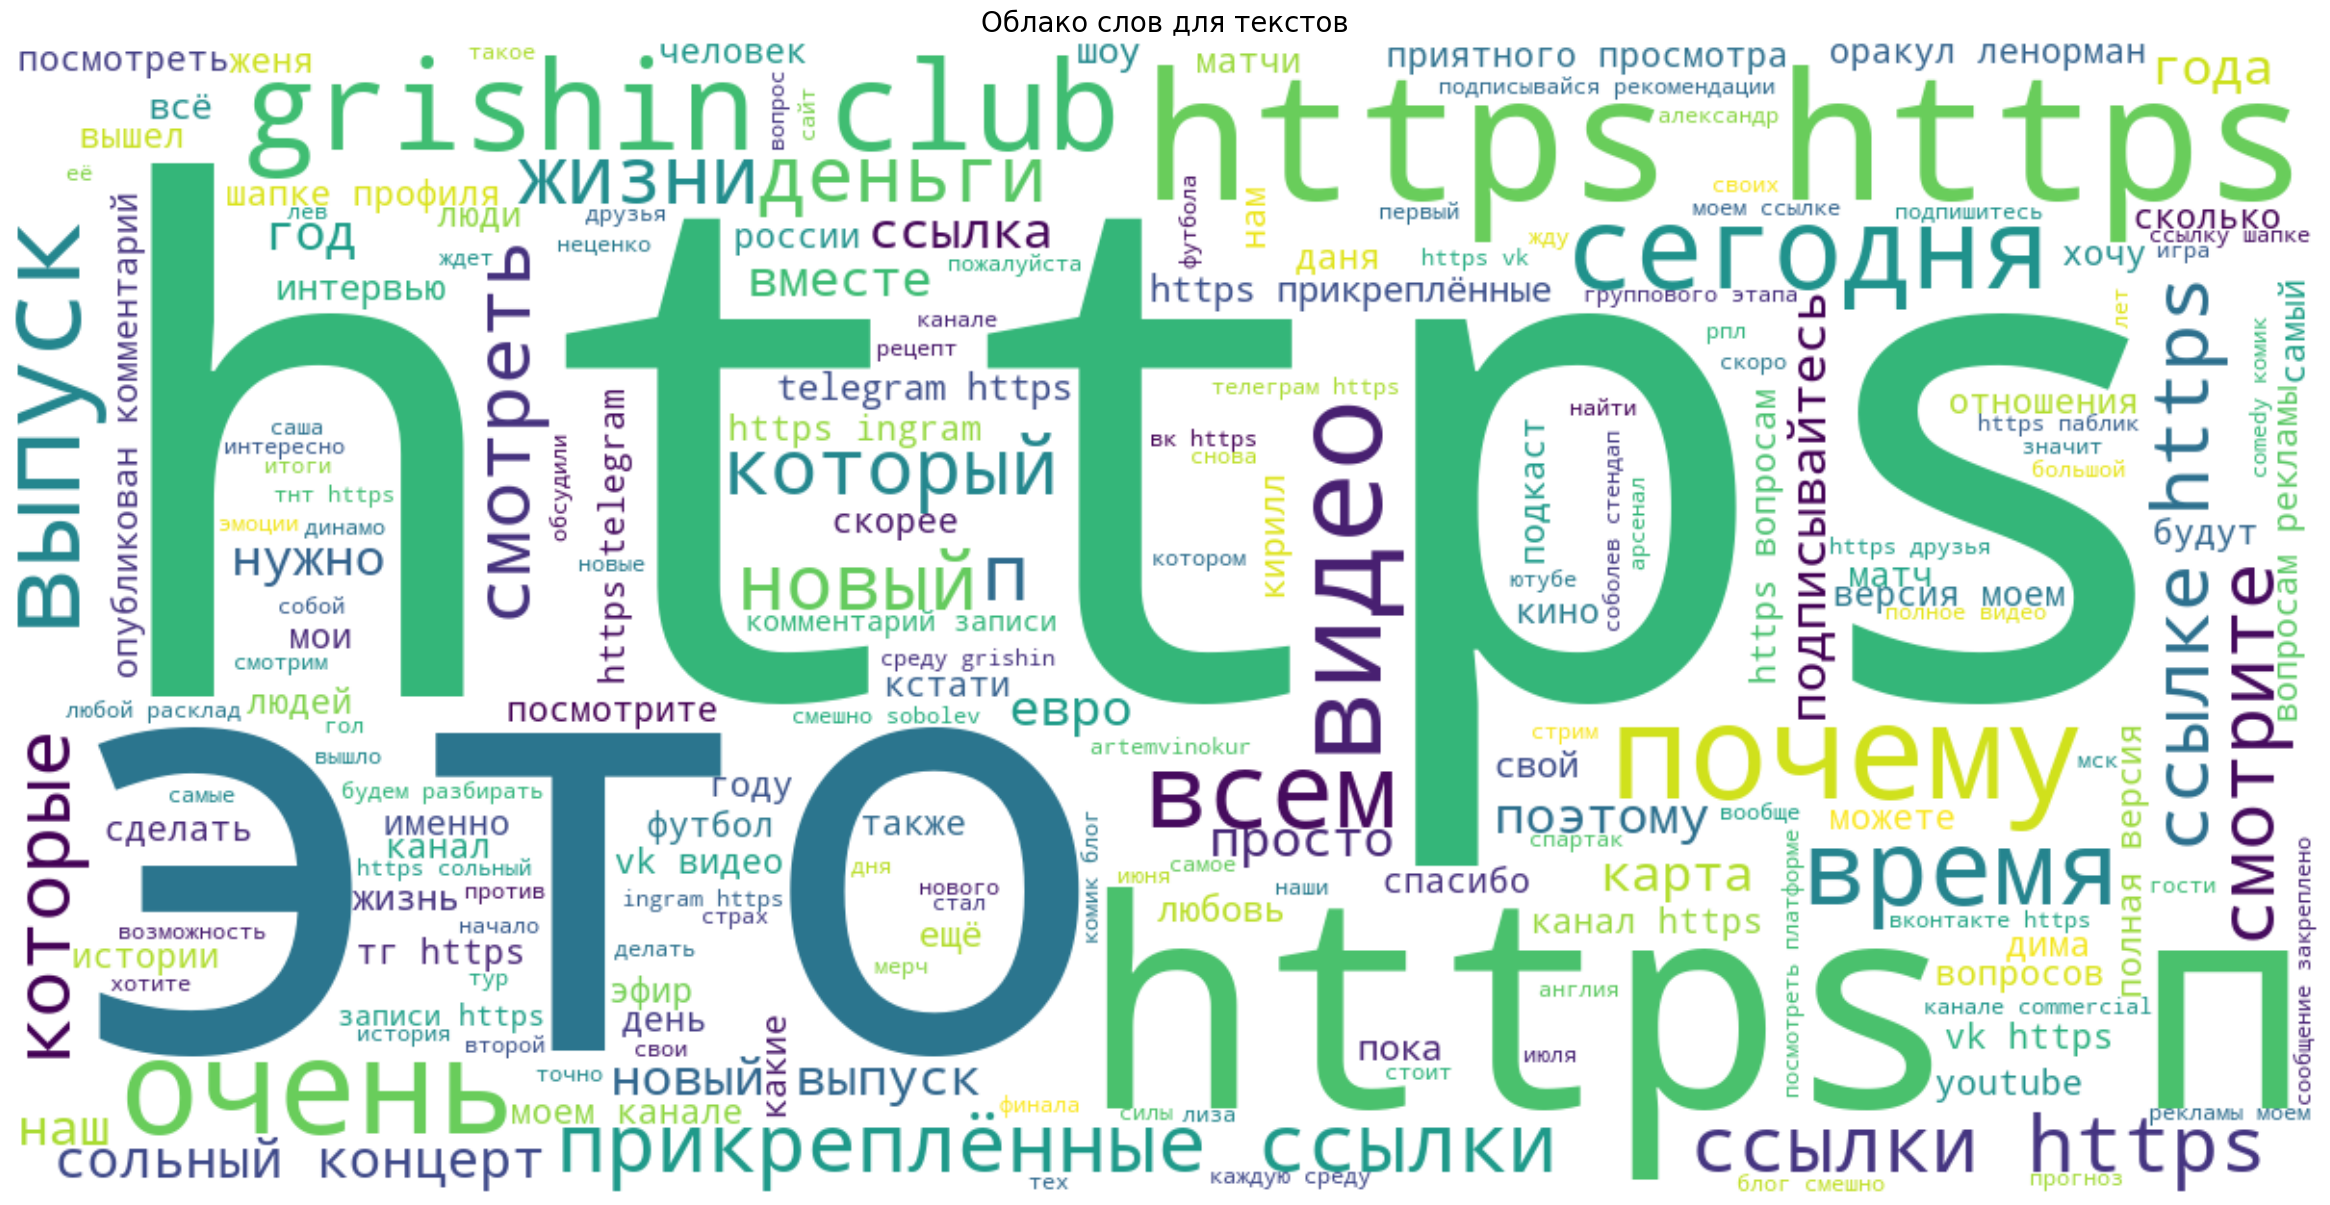

------------------------------------------------------------------------------------------------------------------------------------------------------
График частоты слов:


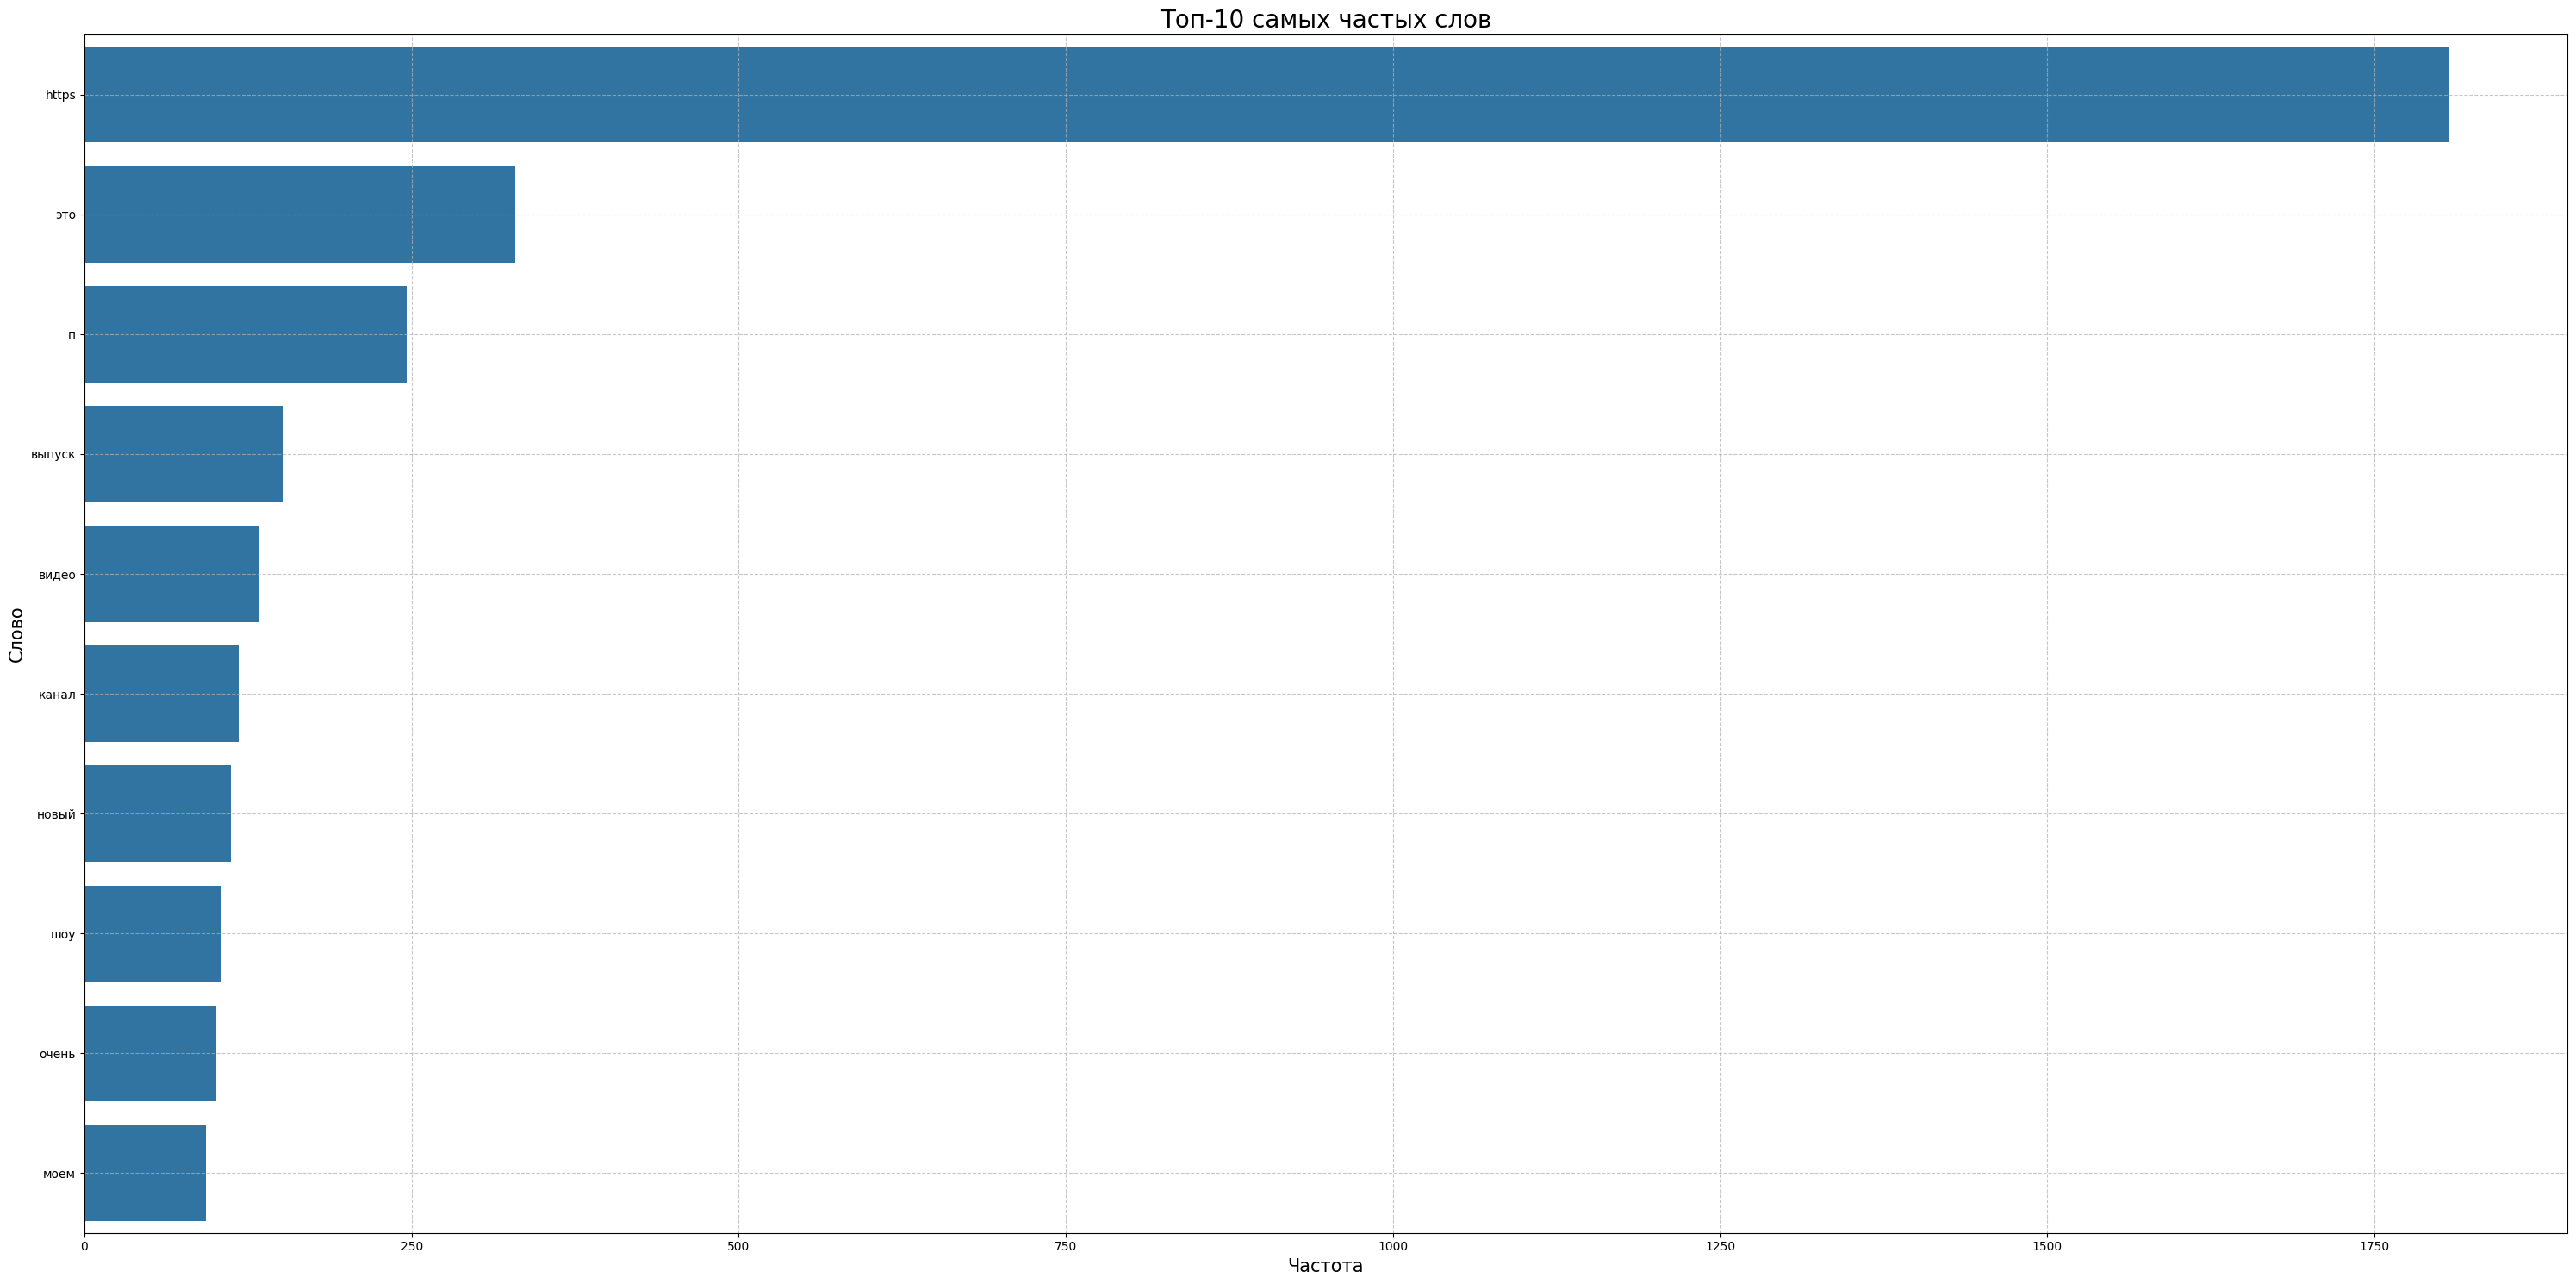

------------------------------------------------------------------------------------------------------------------------------------------------------


In [35]:
# Задаём заглавие для гистограммы
print('-' * 150)
print('Облако (wordcloud) слов:')

# Облако слов
wordcloud = WordCloud(
    width = 1200, 
    height = 600, 
    background_color = 'white'
).generate(' '.join(all_words))

plt.figure(figsize = (30, 15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Облако слов для текстов', fontsize = 20)
plt.show()
print('-' * 150)




# График частоты слов
print('График частоты слов:')

plt.figure(figsize = (30, 15))
sns.barplot(
    x = [count for word, count in common_words], 
    y = [word for word, count in common_words]
)

plt.title('Топ-10 самых частых слов', fontsize = 20)
plt.xlabel('Частота', fontsize = 15)
plt.ylabel('Слово', fontsize = 15)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()
print('-' * 150)

plt.show()

#### $3.3$

Выявим ключевые слова и фразы, для этого используем `KeyBERT` для извлечения ключевых слов из каждого текста:

In [54]:
# Инициализация модели KeyBERT
kw_model = KeyBERT()


# Извлечение ключевых слов
keywords = []
for text in text_df['doc_text']:
    kws = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='russian')
    keywords.append([kw[0] for kw in kws[:2]])  # Берем топ-2 ключевых слова

# Добавление ключевых слов в DataFrame
text_df['keywords'] = keywords



# Вывод результатов
print('Примеры ключевых слов:')
print('-' * 25)
print()

print(text_df[['doc_text', 'keywords']].head())
print('-' * 65)

Примеры ключевых слов:
-------------------------

                                            doc_text keywords
0  Твой лучший секс спрятан здесь 🔞  Делюсь канал...       []
1  ⭐️  Кнопка: ⭐️START⭐️(https://t.me/major/start...       []
2  А продолжение где? Правильно. В моем сообществ...       []
3  Тем временем моя авторская телега уверенно в т...       []
4  У меня есть двоюродная сестра, у нее есть сын ...       []
-----------------------------------------------------------------


## <CENTER> **`4.` Machine Learning**

На данном этапе мы будем использовать подход с `SentenceTransformer` для обработки текста, чтобы выполнить лемматизацию и поиск позиций.

#### $4.1$

Загружаем модель:

In [55]:
# Загружаем модель sentence-transformers
ST_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print('Модель загружена')

Модель загружена


#### $4.2$

Создаём функцию для организации поиска:

In [56]:
# Функция для поиска наиболее близкого слова в документе
def semantic_search_in_document(document, query, model):
    
    
    """
    Ищет слово в документе, наиболее близкое по смыслу к заданному запросу.

    Args:
        document (str): Строка (документ), в которой выполняется поиск.
        query (str): Запрос (словосочетание) для поиска.
        model: Модель sentence-transformers для создания эмбеддингов.

    Returns:
        dict: Словарь с результатами поиска:
            - "document": Исходный документ.
            - "score": Вероятность совпадения (от 0 до 1).
            - "positions": Позиции найденного слова в формате (start-end) в символах.
            - "matched_word": Найденное слово.
    """
    
    # Функция для очистки текста
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    
    doc_cleaned = clean_text(document)
    query_cleaned = clean_text(query)
    
    doc_words = doc_cleaned.split()
    query_words = query_cleaned.split()
    
    
    # Проверка на длину запроса
    if len(query_words) > 2:
        return {
            'document': document,
            'distance': 1.0,
            'positions': '0-0',
            'matched_word': ''
        }
    
    
    # Получаем эмбеддинги для всего документа и запроса
    doc_embedding = model.encode(doc_cleaned, convert_to_tensor=True)
    query_embedding = model.encode(query_cleaned, convert_to_tensor=True)
    
    # Вычисляем косинусное сходство между запросом и документом
    cosine_similarity = util.cos_sim(query_embedding, doc_embedding)[0]
    
    # Косинусное расстояние = 1 - косинусное сходство
    cosine_distance = 1.0 - cosine_similarity
    
    
    # Если косинусное расстояние слишком большое (> 0.5), запрос не связан с документом
    if cosine_distance > 0.5:
        return {
            'document': document,
            'distance': float(cosine_distance),
            'positions': '0-0',
            'matched_word': ''
        }
    
    
    # Находим ближайшее слово для определения позиции
    doc_words_embeddings = model.encode(doc_words, convert_to_tensor=True)
    word_cosine_scores = util.cos_sim(query_embedding, doc_words_embeddings)[0]
    best_word_idx = np.argmax(word_cosine_scores)
    best_word = doc_words[best_word_idx]
    
    # Определяем позиции найденного слова
    start_pos = document.lower().find(best_word)
    end_pos = start_pos + len(best_word) if start_pos != -1 else 0
    positions_str = f"{start_pos}-{end_pos}" if start_pos != -1 else "0-0"
    
    
    return {
        'document': document,
        'distance': float(cosine_distance),
        'positions': positions_str,
        'matched_word': best_word
    }

#### $4.3$

Организовываем поиск:

In [61]:
# Заданные списки строк (документы) и словосочетаний
documents = [
    'доченька твоя совсем большая стала',
    'в лесу растёт высокое дерево',
    'портфель лежит в шкафу дома',
    'институт находится в центре города',
    'вся дорога забита деревьями и цветами',
    'в следующее воскресенье я собираюсь в питер',
    'у меня сломалась стиралка прикинь',
    'садись в машину и поехали уже',
    'сколько стоит ремонт стиральной машины',
    'ты возьми корзину прежде чем набрать продукты',
    'его сегодня утром отвезли в ближайший госпиталь'
]


queries = [
    'дочь',
    'дерево',
    'портфель',
    'институт',
    'дерево',
    'санкт петербург',
    'стиральная машина',
    'автомобиль',
    'автомобиль',
    'звонить',
    'больница'
]



# Проверяем, что длины списков совпадают
assert len(documents) == len(queries), 'Длина списков documents и queries должна совпадать!'

# Выполняем поиск
results = []
for doc, query in zip(documents, queries):
    result = semantic_search_in_document(doc, query, ST_model)
    
    # Добавляем результат только если косинусное расстояние <= 0.5
    if result['distance'] <= 0.5:
        short_doc = result['document'][:50] + "..." if len(result['document']) > 50 else result['document']
        results.append({
            'документ': short_doc,
            'словосочетание': query,
            'позиция': result['positions'],
            'косинусное_расстояние': result['distance']
        })



# Выводим результаты
print('Результат работы модели:')
print('-' * 30)
print()

print('ДОКУМЕНТ'.ljust(50), 'СЛОВОСОЧЕТАНИЕ'.ljust(20), 'ВЫВОД')
for res in results:
    print(
        res['документ'].ljust(50),
        res['словосочетание'].ljust(20),
        f"позиция: {res['позиция']}".ljust(25),
        f"косинусное расстояние: {res['косинусное_расстояние']:.3f}"
    )

print('-' * 130)

Результат работы модели:
------------------------------

ДОКУМЕНТ                                           СЛОВОСОЧЕТАНИЕ       ВЫВОД
доченька твоя совсем большая стала                 дочь                 позиция: 0-8              косинусное расстояние: 0.412
в лесу растёт высокое дерево                       дерево               позиция: 22-28            косинусное расстояние: 0.212
портфель лежит в шкафу дома                        портфель             позиция: 0-8              косинусное расстояние: 0.256
институт находится в центре города                 институт             позиция: 0-8              косинусное расстояние: 0.466
вся дорога забита деревьями и цветами              дерево               позиция: 18-27            косинусное расстояние: 0.495
садись в машину и поехали уже                      автомобиль           позиция: 9-15             косинусное расстояние: 0.368
его сегодня утром отвезли в ближайший госпиталь    больница             позиция: 38-47            косин

#### $4.4$

Сохраняем полученную результаты:

In [62]:
# Сохраняем модель
os.makedirs('ST_model', exist_ok=True)
joblib.dump(results, 'ST_model/search_results.pkl')


# Сохраняем модель в папку ST_model/
os.makedirs('ST_model', exist_ok = True)  # Создаём папку, если её нет
ST_model.save('ST_model/semantic_search_model')
print('Модель сохранена в ST_model/semantic_search_model')



# Проверяем, существует ли сохранённая модель
if os.path.exists('ST_model/semantic_search_model'):
    ST_model = SentenceTransformer('ST_model/semantic_search_model')
    print('Модель загружена из локального файла')
    
else:
    ST_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    print('Модель загружена из интернета')
    
    os.makedirs('ST_model', exist_ok = True)
    ST_model.save('ST_model/semantic_search_model')
    print('Модель сохранена в ST_model/semantic_search_model')

Модель сохранена в ST_model/semantic_search_model
Модель загружена из локального файла
